# Assignment 1 Notebook

## Immporting Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix


## Loading Dataset and Remove 'Outlier' Values

## Defining the 'OutlierRemover' Class

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - (IQR * self.factor)
        self.upper_bound = Q3 + (IQR * self.factor)
        return self

    def transform(self, X, y=None):
        X = np.where(X < self.lower_bound, self.lower_bound, X)
        X = np.where(X > self.upper_bound, self.upper_bound, X)
        return X

file_path = '/content/data.csv'
df = pd.read_csv(file_path)

## Explolatory Data Analysis(EDA)

## Basic DataFrame information

In [ ]:
print(df.describe())
print(df.info())
print(df.isnull().sum())

                 ts             co       humidity            gas  \
count  4.051840e+05  405184.000000  405184.000000  405184.000000   
mean   1.592943e+09       0.004639      60.511694       0.007237   
std    4.557306e+06       0.001250      11.366489       0.001444   
min    1.590000e+09       0.001171       1.100000       0.002693   
25%    1.590000e+09       0.003919      51.000000       0.006456   
50%    1.590000e+09       0.004812      54.900000       0.007489   
75%    1.600000e+09       0.005409      74.300003       0.008150   
max    1.600000e+09       0.014420      99.900002       0.016567   

               smoke           temp  
count  405184.000000  405184.000000  
mean        0.019264      22.453987  
std         0.004086       2.698347  
min         0.006692       0.000000  
25%         0.017024      19.900000  
50%         0.019950      22.200000  
75%         0.021838      23.600000  
max         0.046590      30.600000  
<class 'pandas.core.frame.DataFrame'>
RangeIn

## Pairplot to visualize relationships

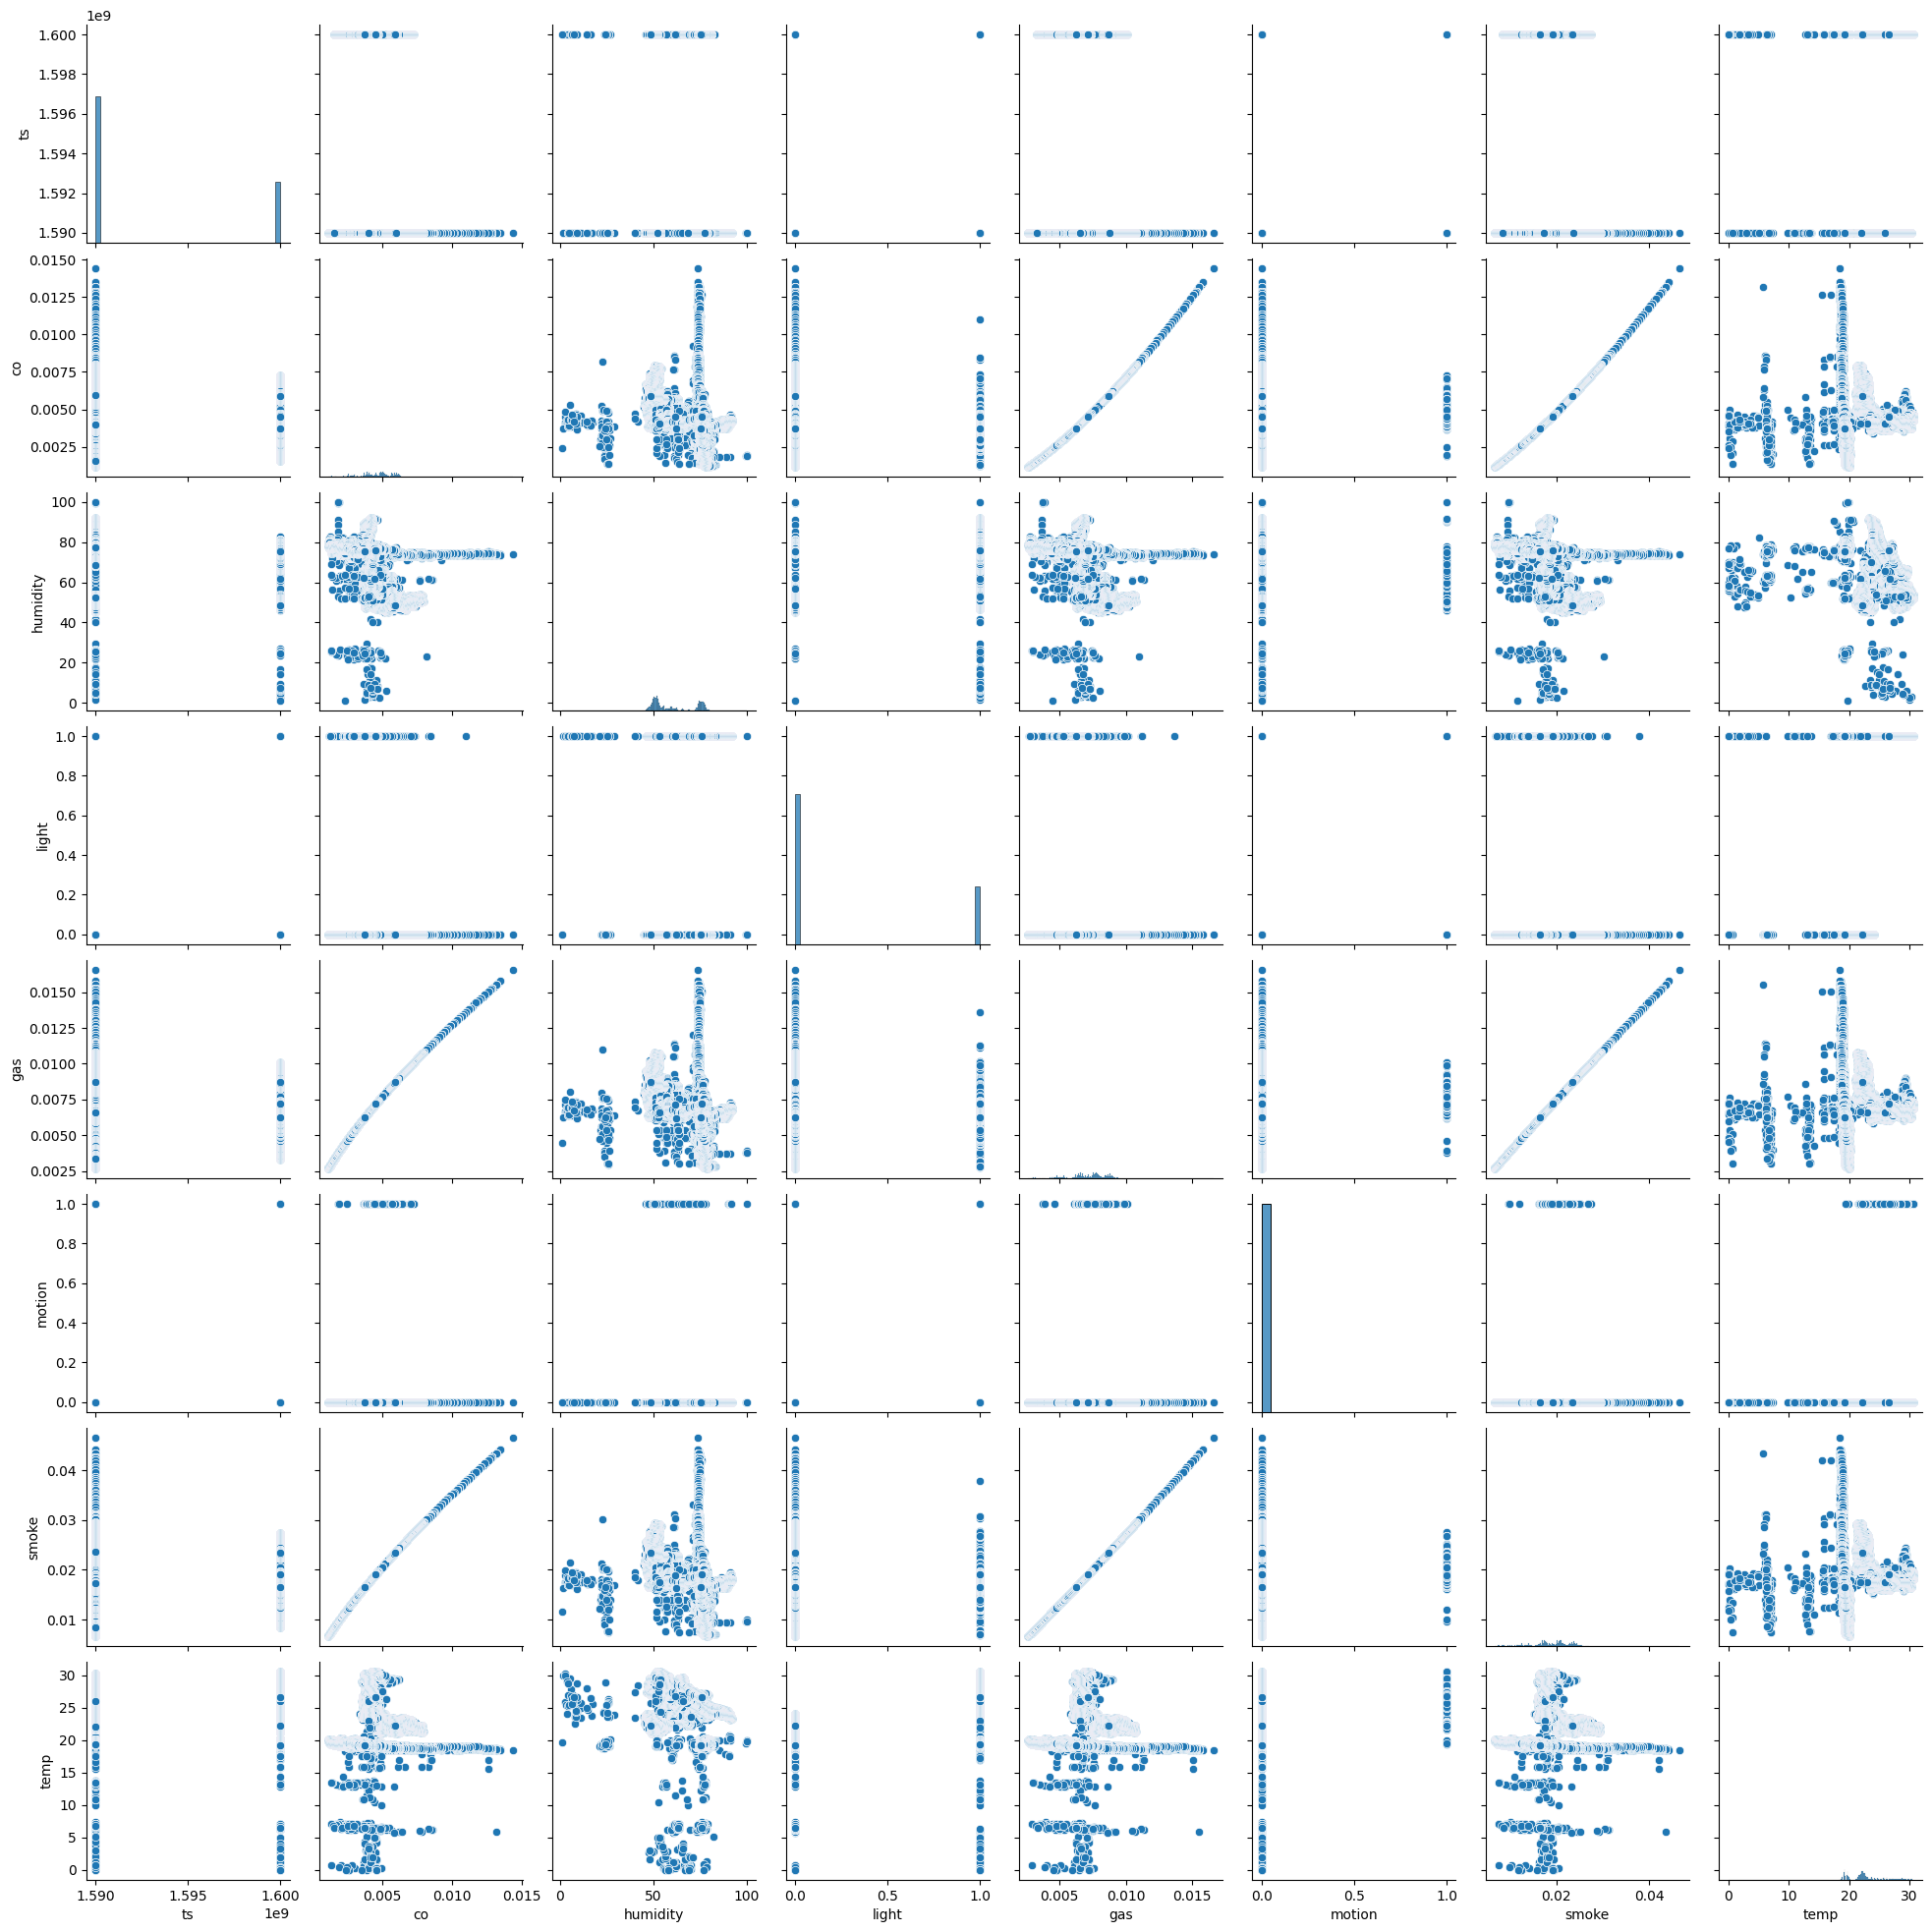

In [ ]:
sns.pairplot(df)
plt.show()


## Correlation heatmap

<ipython-input-5-fb547dfd502c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f")


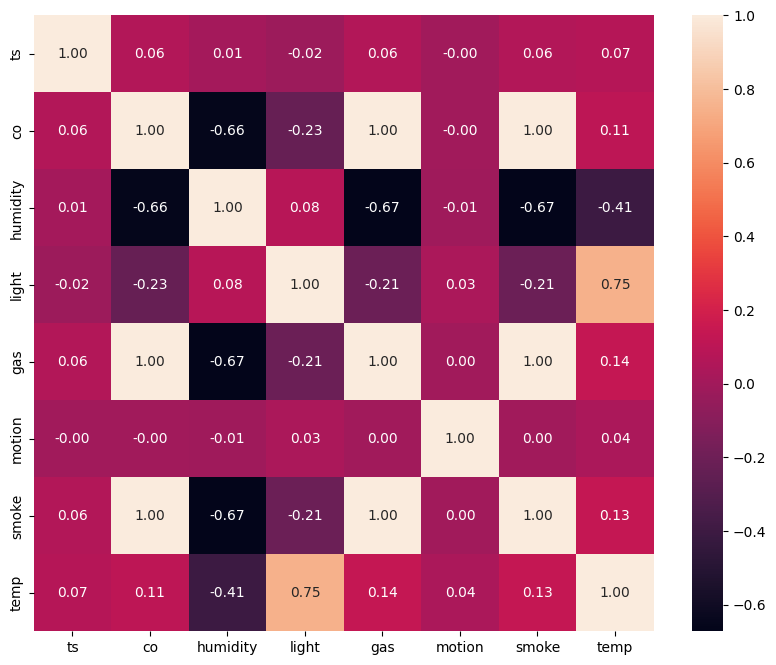

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## Preprocessing

In [ ]:
# Feature selection
X = df.drop('motion', axis=1)
y = df['motion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifying numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('outliers', OutlierRemover())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Append classifier to preprocessing pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

## Model Construction and Evaluation

## Train the model

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('outliers',
                                                                   OutlierRemover())]),
                                                  Index(['ts', 'co', 'humidity', 'gas', 'smoke', 'temp'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['device'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

## Plot the feature importances

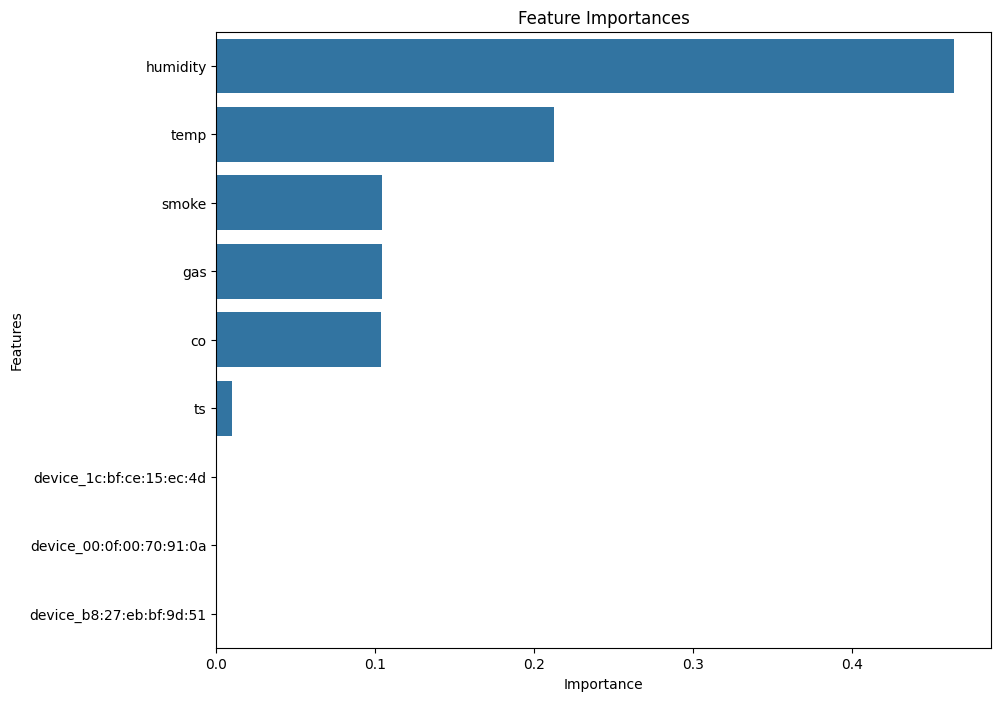

In [ ]:
# Extract feature importances directly from the fitted model
feature_importances = clf.named_steps['classifier'].feature_importances_

# Retrieve transformed feature names for both numeric and categorical features
transformers = clf.named_steps['preprocessor'].transformers_
feature_names = []
for name, transformer, columns in transformers:
    if name == 'num':
        feature_names.extend(columns)
    elif name == 'cat':

        cats = transformer.named_steps['onehot'].get_feature_names_out(columns)
        feature_names.extend(cats)

# Combine importances with feature names
importances = pd.Series(data=feature_importances, index=feature_names).sort_values(ascending=False)

# Plot the sorted importances
plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


## Predictions

In [ ]:
y_pred = clf.predict(X_test)

## Evaluation and Accuracy

In [ ]:
# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Accuracy
print(f"Model Accuracy: {clf.score(X_test, y_test):.4f}")

[[80936    15]
 [   85     1]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     80951
        True       0.06      0.01      0.02        86

    accuracy                           1.00     81037
   macro avg       0.53      0.51      0.51     81037
weighted avg       1.00      1.00      1.00     81037

Model Accuracy: 0.9988
